In [610]:
# !!! need to have xlrd==1.2.0, numpy==1.26.4, pandas==1.3.5, or pandas won't read the .xlsx files generated by the software
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
from scipy.constants import g
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 16, 'figure.figsize': (10, 6), 'font.family': 'serif', 'savefig.bbox': 'tight'})
#plt.rcParams.update({'figure.dpi' : 600})

# Get measurements from individual excel files
measurement_numbers = np.arange(6,61)
measurements = []
for i in range(measurement_numbers[-1]+1):
    if i < measurement_numbers[0]:
        measurements.append(np.nan)
        continue
    measurements.append(pd.read_excel(f'measurements/{i}.xlsx', engine='xlrd').values[:,0])
    # clean #NV values
    for j in range(len(measurements[-1])):
        if measurements[-1][j] == '#NV':
            measurements[-1][j] = np.nan

# Get v_stop
v_stop = np.loadtxt("measurements/v_stop.txt")
measurements = measurements[6:]

/var/folders/7j/bs4xx7fn0qs5qbg6nsyxmczr0000gn/T/ipykernel_12595/2931676552.py:20: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. Install openpyxl instead.
  measurements.append(pd.read_excel(f'measurements/{i}.xlsx', engine='xlrd').values[:,0])


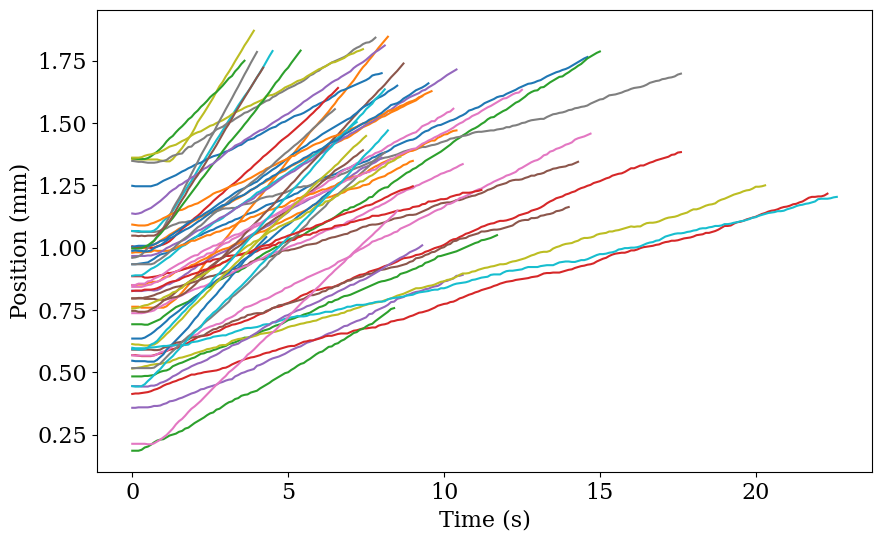

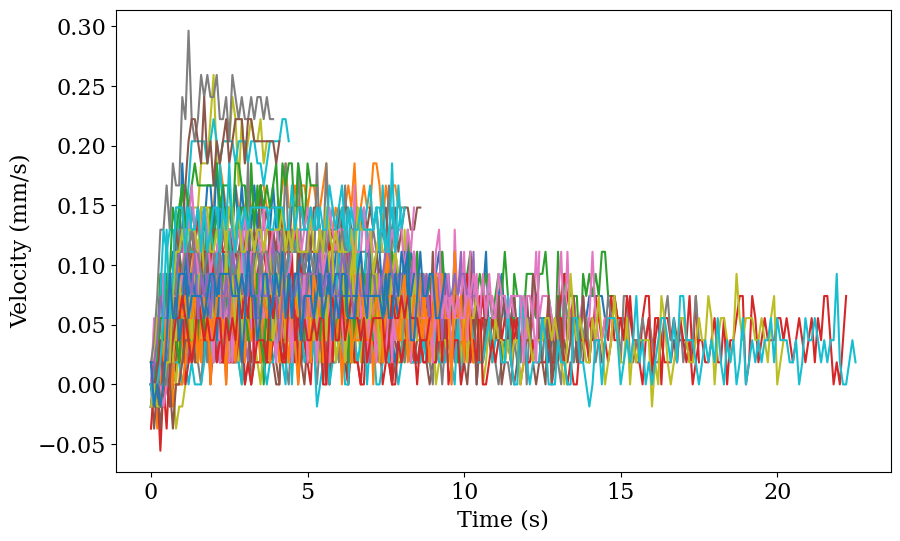

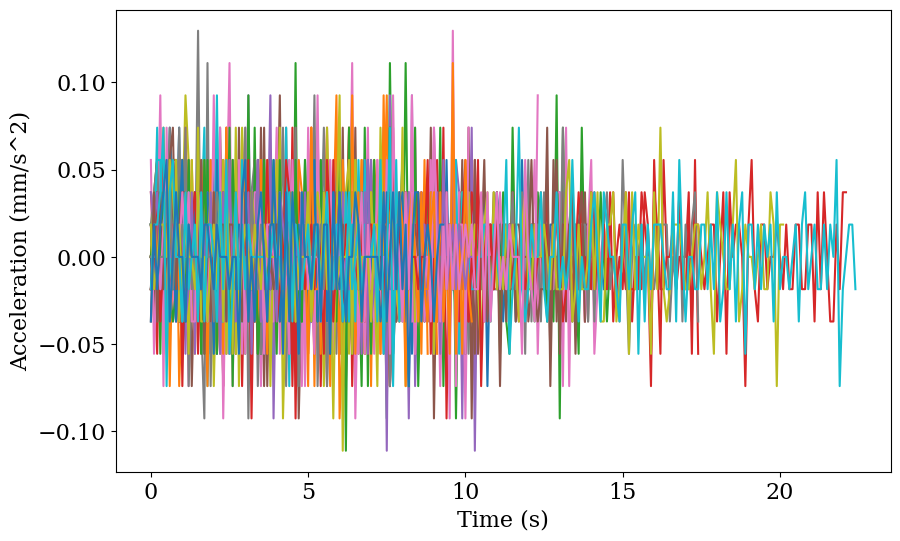

In [611]:
# constants from manual 
rho_oil = 875.3 # kg/m^3
#rho_air = 1.204 # kg/m^3
rho_air = 0.
nu_air = 1.827e-5 # Ps s at 1 atm
d = 6.0/1000 # m (parallel plate distance)
frame_rate = 10 # Hz
conversion_ratio = ufloat(540,1) # px / mm

# convert pixels to mm 
y = [m / conversion_ratio for m in measurements] # mm

# calculate velocities using framerate 
# v is dy/dt = (10 Frame / s) * (dy / 1 Frame)
velocities = [np.diff(m)*(frame_rate) for m in y] # mm/s
accelerations = [np.diff(v) for v in velocities] # mm/s^2

# filter out bad measurements that have unphysical accelerations
threshold = 0.5
velocities = [velocities[v] for v in range(len(velocities)) if all(np.abs(accelerations[v]) < threshold)]
positions = [y[v] for v in range(len(y)) if all(np.abs(accelerations[v]) < threshold)]
v_stop = [v_stop[v] for v in range(len(v_stop)) if all(np.abs(accelerations[v]) < threshold)]
accelerations = [accelerations[v] for v in range(len(accelerations)) if all(np.abs(accelerations[v]) < threshold)]
y_times = [np.arange(0, len(m)/frame_rate, 1/frame_rate) for m in positions]
v_times = [np.arange(0, len(v)/frame_rate, 1/frame_rate) for v in velocities]
a_times = [np.arange(0, len(a)/frame_rate, 1/frame_rate) for a in accelerations]

# Check that all measuremenents look reasonable now
for i in range(len(positions)):
    plt.plot(y_times[i], [y.n for y in positions[i]])
plt.xlabel('Time (s)')
plt.ylabel('Position (mm)')
plt.show()
for m in range(len(velocities)):
    plt.plot(v_times[m], [v.n for v in velocities[m]])
plt.xlabel('Time (s)')
plt.ylabel('Velocity (mm/s)')
plt.show()
for a in range(len(accelerations)):
    plt.plot(a_times[a], [a.n for a in accelerations[a]])
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (mm/s^2)')
plt.show()

In [612]:
# pick out range after terminal velocity is reached
start = 20
end = 140
velocities = [v[start:end] for v in velocities]
positions = [y[start:end] for y in positions]
accelerations = [a[start:end] for a in accelerations]
y_times = [y[start:end] for y in y_times]
v_times = [v[start:end] for v in v_times]
a_times = [a[start:end] for a in a_times]
v_term_mean = [np.mean(v) for v in velocities]

# check data again and v_terms
# colors = plt.cm.rainbow(np.linspace(0, 1, len(v_term)))
# fig = plt.figure()
# for i in range(len(positions)):
#     plt.plot(y_times[i], [y.n for y in positions[i]], color=colors[i], lw=0.75)
# plt.xlabel('Time (s)')
# plt.ylabel('Position (mm)')
# plt.show()
# fig = plt.figure()
# for m in range(len(velocities)):
#     plt.plot(v_times[m], [v.n for v in velocities[m]], color=colors[m], lw=0.75)
# plt.xlabel('Time (s)')
# plt.ylabel('Velocity (mm/s)')
# plt.show()
# fig = plt.figure()
# for v in range(len(v_term_mean)):
#     plt.hlines(v_term_mean[v].n, 0, 1, colors=colors[v],lw=0.75)
# plt.xlabel('Measurement')
# plt.ylabel('Terminal Velocity (mm/s)')
# plt.show()
# fig = plt.figure()
# for a in range(len(accelerations)):
#     plt.plot(a_times[a], [a.n for a in accelerations[a]], color=colors[a],lw=0.75)
# plt.xlabel('Time (s)')
# plt.ylabel('Acceleration (mm/s^2)')
# plt.show()

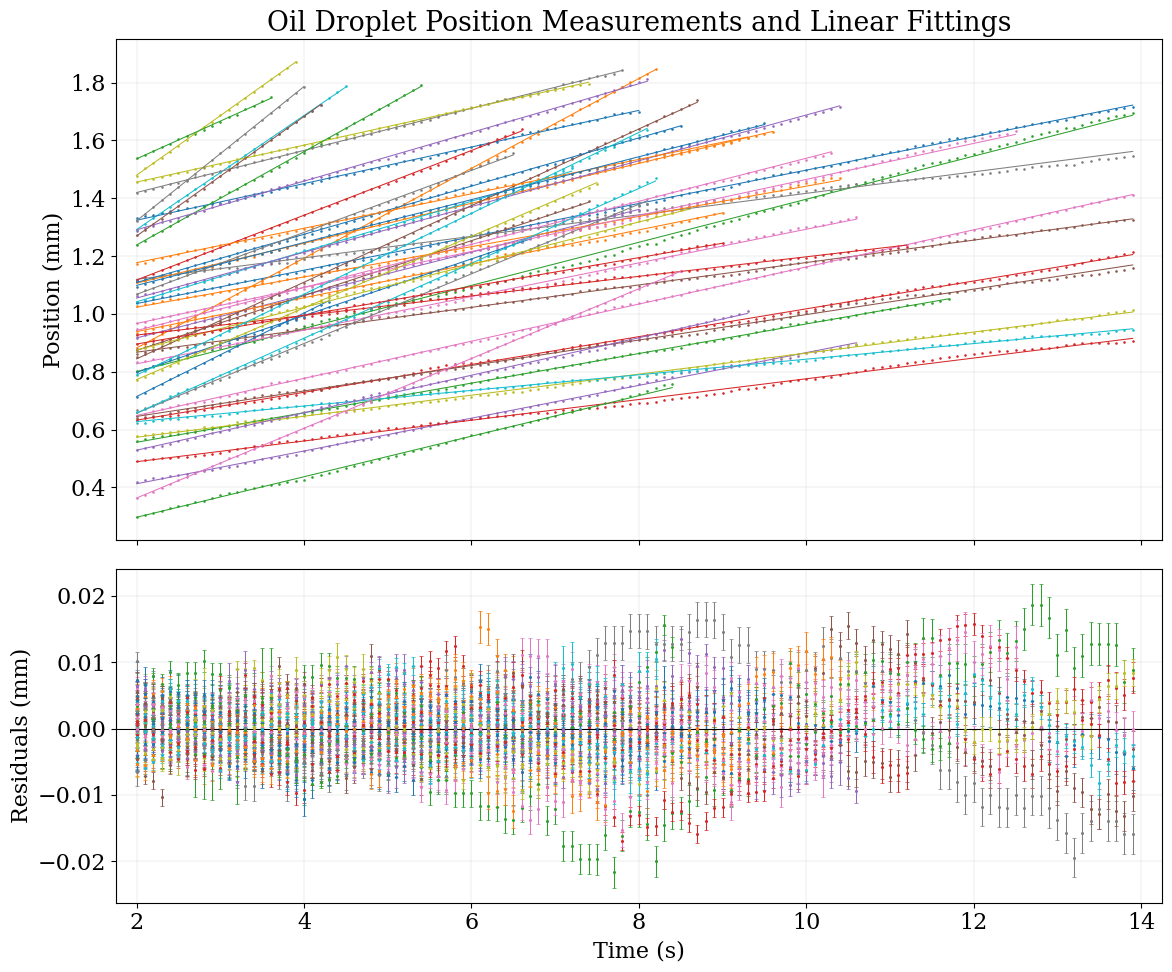

In [613]:
# data is very noisy so we will not use the previously calculated velocities or accelerations. We will calculate 
# v_term directly from position data with curve_fit. 

v_term_fit = []
def linear(x, m, b):
    return m*x + b

# evaluate fit with uncertainties
def get_position(popt, pcov, t):
    m = ufloat(popt[0], np.sqrt(pcov[0,0]))
    b = ufloat(popt[1], np.sqrt(pcov[1,1]))
    v_term_fit.append(m)
    return [linear(i, m, b) for i in t]

y_fit = []
for drop in range(len(positions)):
    popt, pcov = curve_fit(linear, y_times[drop], [y.n for y in positions[drop]], sigma=[y.s for y in positions[drop]], absolute_sigma=True)
    y_fit.append(get_position(popt,pcov,y_times[drop]))

# get residuals for the y fits 
residuals = [positions[i] - y_fit[i] for i in range(len(positions))]

# Plot positions and fits
fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 2]}, sharex=True)
axs[0].set_title('Oil Droplet Position Measurements and Linear Fittings')
axs[0].set_xlim(1.75, 14.25)
for drop in range(len(positions)):
    axs[0].scatter(y_times[drop], [y.n for y in positions[drop]], s=0.75)
    axs[0].plot(y_times[drop], [y.n for y in y_fit[drop]], lw=0.75)
axs[0].set_ylabel('Position (mm)')
axs[0].grid(lw=0.15)

# Plot residuals
for r in range(len(residuals)):
    axs[1].errorbar(y_times[r], [r.n for r in residuals[r]], yerr=[r.s for r in residuals[r]], fmt='o', ms=1.2,elinewidth=.75, capsize=1.75,capthick=0.5)
axs[1].axhline(0, color='black', lw=0.75)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Residuals (mm)')
axs[1].grid(lw=0.15)
plt.tight_layout()
plt.show()

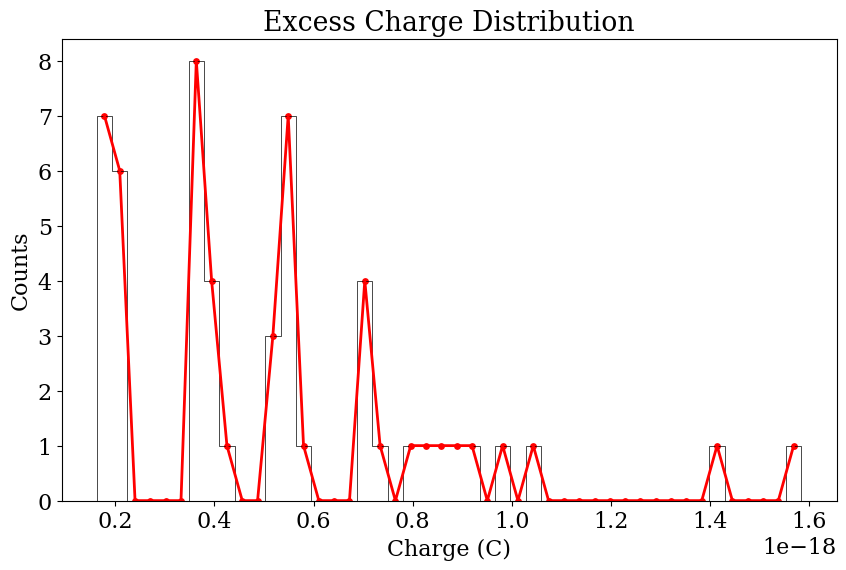

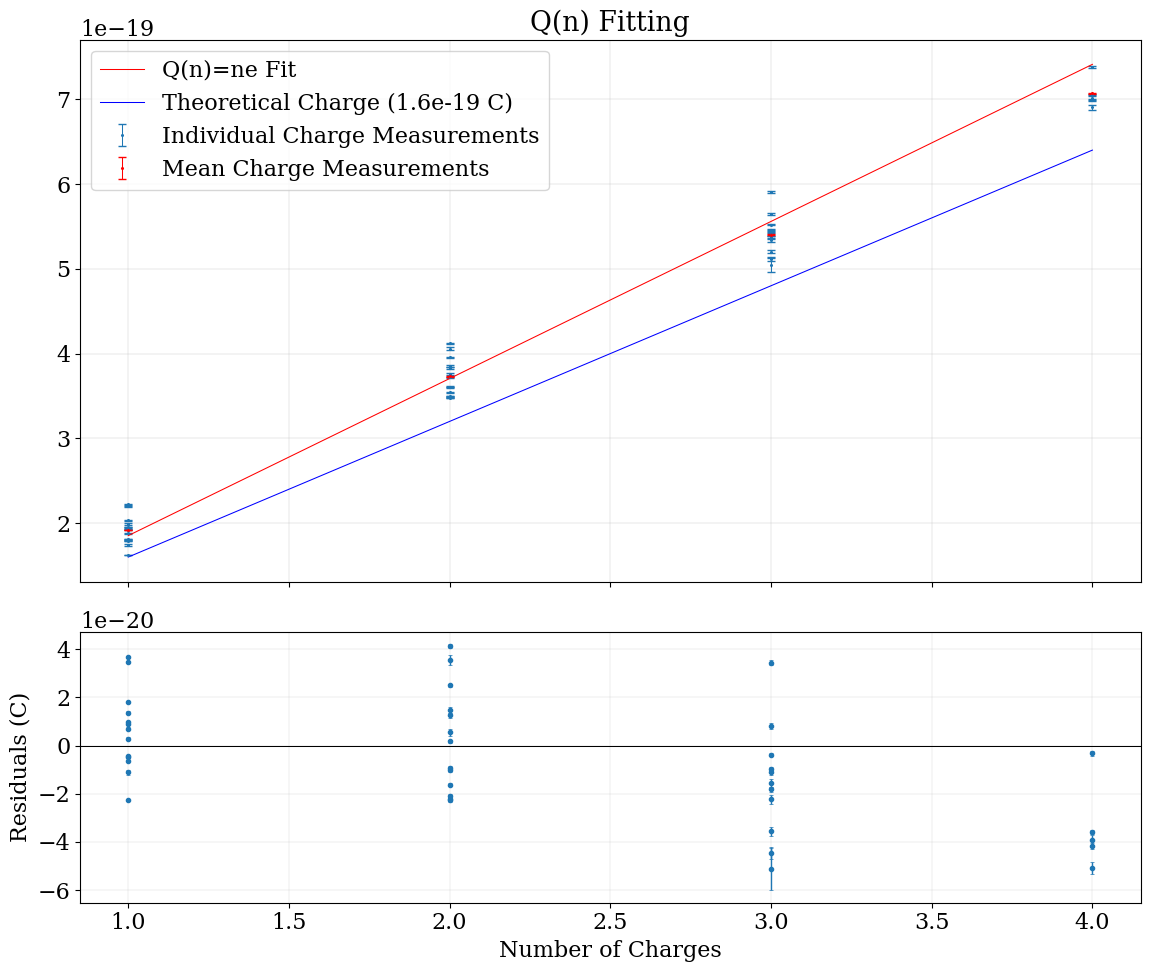

Elementary Charge: (1.9+/-0.5)e-19


In [617]:
def excess_q(v_term, v_stop):
    C = (18*np.pi*nu_air**(3/2)*d)/np.sqrt(2*g*(rho_oil - rho_air))
    return C*(v_term**(3/2))/(v_stop)
def Q(n, q):
    return n*q

excess_qs = np.array([excess_q(v_term_fit[i]/1000, v_stop[i]) for i in range(len(v_term_fit))])
plt.title("Excess Charge Distribution")
plt.xlabel("Charge (C)")
plt.ylabel("Counts")
h1=plt.hist([q.n for q in excess_qs], bins=46, edgecolor='black', linewidth=0.5,histtype='step')
counts = h1[0]
bin_edges = h1[1]
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
plt.plot(bin_centers, counts, lw=2, color='red', ls='-')
plt.scatter(bin_centers, counts, color='red', marker='.',s=60)
plt.show()

# The first method we are trying is to assume that the groupings we see in in the histogram correspond to integer multiples of the elementary charge.
# We use conservation of charge with our measured excess charge and number of charges from the first four histogram groupings to solve for the elementary charge. 

counts_n = [13,13,11,5]
q_sort = np.sort(excess_qs)
q_means = []
n_all_points = []
n_means = [i for i in range(1,len(counts_n)+1)]
for i in range(1,len(counts_n)+1):
    n_all_points+=[i for j in range(counts_n[i-1])]
    q_means.append(np.mean([q for q in q_sort[:counts_n[i-1]]]))
    q_sort = q_sort[counts_n[i-1]:]
q_sort = np.sort(excess_qs)[:len(n_all_points)]
popt, pcov = curve_fit(Q, n_means, [q.n for q in q_means], sigma=[q.s for q in q_means], absolute_sigma=True, p0=1.6e-19)

# Plot the fit 
fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
axs[0].set_title("Q(n) Fitting")
axs[0].errorbar(n_all_points, [q.n for q in q_sort], yerr=[q.s for q in q_sort], fmt='o', ms=1.2,elinewidth=.75, capsize=3,capthick=1, label="Individual Charge Measurements")
axs[0].errorbar(n_means, [q.n for q in q_means], color='red', yerr=[q.s for q in q_means], fmt='o', ms=1.2,elinewidth=.75, capsize=3,capthick=1, label="Mean Charge Measurements")
axs[0].plot(n_means, Q(np.array(n_means), *popt), color='red', lw=0.75, label="Q(n)=ne Fit")
axs[0].plot(n_means, Q(np.array(n_means), 1.6e-19), color='blue', lw=0.75, label="Theoretical Charge (1.6e-19 C)")
axs[0].grid(lw=0.2)
axs[0].legend()

elem_charge = ufloat(popt[0], np.sqrt(pcov[0,0]))

# Plot residuals
residuals = [q_sort - Q(np.array(n_all_points), elem_charge)]
axs[1].errorbar(n_all_points, [r.n for r in residuals[0]], yerr=[r.s for r in residuals[0]], fmt='o', ms=3 ,elinewidth=1, capsize=1.75,capthick=0.5)
axs[1].axhline(0, color='black', lw=0.75)
axs[1].set_xlabel('Number of Charges')
axs[1].set_ylabel('Residuals (C)')
axs[1].grid(lw=0.15)
plt.tight_layout()
plt.show()

# The biggest uncertainty here is the estimate for n based on the histogram groupings, which may look differently based on bin size. We estimate the uncertainty in n to be 0.25. It would be better 
# to have this directly in the fit, but curve_fit cannot do that so we add it here as a rough estimate.
print(f"Elementary Charge: {Q(ufloat(1,0.25), elem_charge)}")

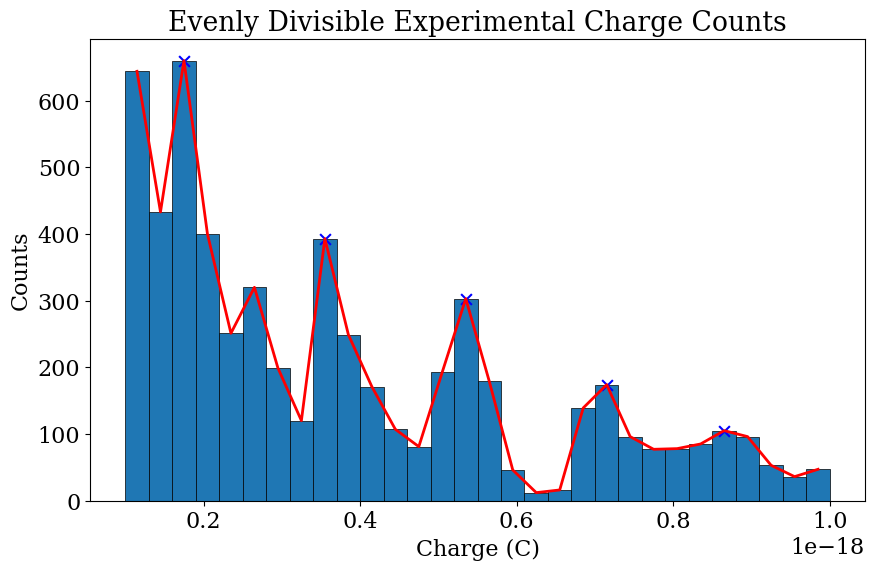

Peaks:  [1.749999999999998e-19+/-5.999999999999983e-20
 3.5499999999999927e-19+/-5.999999999999983e-20
 5.349999999999987e-19+/-5.999999999999983e-20
 7.149999999999982e-19+/-5.999999999999983e-20
 8.649999999999978e-19+/-5.999999999999983e-20]
------------------------
Differences in peaks:  [1.7999999999999948e-19+/-8.485281374238546e-20
 1.7999999999999943e-19+/-8.485281374238546e-20
 1.7999999999999952e-19+/-8.485281374238546e-20
 1.4999999999999959e-19+/-8.485281374238546e-20]
------------------------
Elementary Charge:  (1.72+/-0.21)e-19


In [618]:
# check if hypothetical charges within the range of the first bin divide evenly into the experimental charges. 
possible_e = np.arange(1.0e-19,1.0e-18,0.01e-19)
charge_multiples = []
def is_int_multiple(q, q0):
    #print(q/q0, np.round(q/q0))
    return np.allclose(q/q0, np.round(q/q0), rtol=0.05)
for q in excess_qs:
    for q0 in possible_e:
        if is_int_multiple(q.n, q0):
            #print(f"{q.n} is a {np.round(q.n/q0)}x integer multiple of {q0} within tolerance {np.abs(q.n/q0 - np.round(q.n/q0))}")
            charge_multiples.append([q0, np.abs(q/q0)])

h2 = plt.hist([m[0] for m in charge_multiples], bins=30, edgecolor='black', linewidth=0.5)  
bin_centers2 = (h2[1][:-1] + h2[1][1:])/2
peaks, _ = find_peaks(h2[0], prominence=1, threshold=5)
peaks = np.delete(peaks, 1)
plt.plot(bin_centers2, h2[0], lw=2, color='red', ls='-')
plt.scatter(bin_centers2[peaks], h2[0][peaks], color='blue', marker='x',s=60)
plt.title("Evenly Divisible Experimental Charge Counts")
plt.xlabel("Charge (C)")
plt.ylabel("Counts")
plt.show()

# Once again our largest uncertainty is in the x axis which is primarily determined by the bin size. We estimate the uncertainty as twice average difference between the bin centers. This was chosen 
# by changing the bin size and seeing how much the peaks typically moved. 
bin_uncertainty = 2*np.mean(np.diff(bin_centers2))
bin_centers2 = np.array([ufloat(bin_centers2[i], bin_uncertainty) for i in range(len(bin_centers2))])
elementary_charge = np.mean(np.diff(bin_centers2[peaks]))

print("Peaks: ", bin_centers2[peaks])
print("------------------------")
print("Differences in peaks: ", np.diff(bin_centers2[peaks]))
print("------------------------")
print("Elementary Charge: ", elementary_charge)